In [2]:
import re
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams["font.family"] = "monospace"

In [3]:
NUM_DEVICES = 8
BATCH_PER_DEVICE = 1
SEQ_LEN = 64 * 1024

STEP_PATTERN = r"step:([0-9]+)/([0-9]+)"
VAL_LOSS_PATTERN = r"val_loss:([0-9.]+)"
TRAIN_TIME_PATTERN = r"train_time:([0-9]+)ms"

In [ ]:
IMAGES_SAVE_PATH = "."

old_record_filenames = glob.glob("../120424_ValueEmbed/*.txt")
new_record_filenames = glob.glob("*.txt")
all_filenames = [
    old_record_filenames,
    new_record_filenames,
]
filenames = (
    old_record_filenames
    + new_record_filenames
)

labels = [
    "12/04 record, 8xH100",
    "12/07 record, 8xH100",
]

color_palettes = [
    # sns.dark_palette("#69d", n_colors=len(old_record_filenames)),
    ["Blue" for _ in old_record_filenames],
    # sns.color_palette("YlOrBr", n_colors=len(new_record_filenames)),
    ["Red" for _ in new_record_filenames],
]

In [53]:
files = [open(filename, "r").readlines() for filename in filenames]

In [54]:
steps = [[] for _ in range(len(files))]
val_losses = [[] for _ in range(len(files))]
train_times = [[] for _ in range(len(files))]
train_times_min = [[] for _ in range(len(files))]
train_tokens = [[] for _ in range(len(files))]
for idx, file in enumerate(files):
    for line in file:
        if line.startswith("step:") and "val_loss:" in line:
            step = re.search(STEP_PATTERN, line).group(1)
            val_loss = re.search(VAL_LOSS_PATTERN, line).group(1)
            train_time = re.search(TRAIN_TIME_PATTERN, line).group(1)
            steps[idx].append(int(step))
            val_losses[idx].append(float(val_loss))
            train_times[idx].append(float(train_time))
    steps[idx] = np.array(steps[idx])
    val_losses[idx] = np.array(val_losses[idx])
    train_times[idx] = np.array(train_times[idx])
    train_times_min[idx] = train_times[idx] / 1000 / 60
    train_tokens[idx] = NUM_DEVICES * BATCH_PER_DEVICE * SEQ_LEN * steps[idx]

In [55]:
step_avg = [train_times[i][-1] / steps[i][-1] for i in range(len(files))]
final_val_losses = [val_losses[i][-1] for i in range(len(files))]

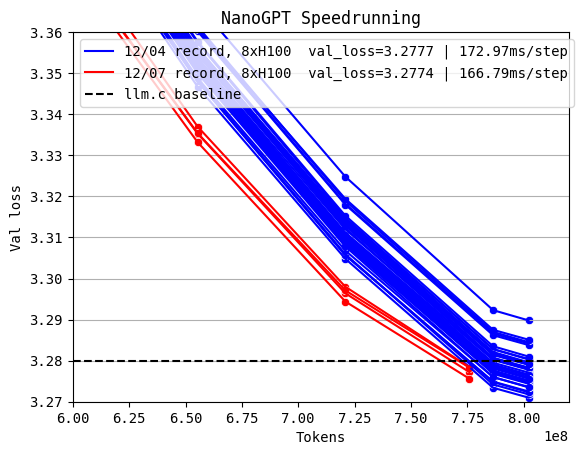

In [56]:
offset = 0
for i, palette in enumerate(color_palettes):
    n = len(all_filenames[i])
    avg_final_val_loss = np.mean(final_val_losses[offset:offset+n])
    avg_ms_per_step = np.mean(step_avg[offset:offset+n])
    run_label = labels[i]

    for idx, (tok, val_loss) in enumerate(
        zip(train_tokens[offset:offset+n], val_losses[offset:offset+n])
    ):
        label = (
            f"{run_label:<22}val_loss={avg_final_val_loss:.4f} | {avg_ms_per_step:.2f}ms/step"
            if idx == 0
            else None
        )
        sns.scatterplot(x=tok, y=val_loss, linewidth=0.5, color=palette[idx])
        sns.lineplot(x=tok, y=val_loss, label=label, color=palette[idx])

    offset += n

plt.axhline(y=3.28, color="black", linestyle="--", label="llm.c baseline")

plt.title("NanoGPT Speedrunning")
plt.legend(loc="upper left", )
plt.ylim(3.27, 3.36)
plt.yticks(np.linspace(3.27, 3.36, 10))
# plt.xlim(1.2e9, 1.6e9)
plt.xlim(0.6e9, 0.82e9)
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("Tokens")
plt.savefig(f"{IMAGES_SAVE_PATH}/nanogpt_speedrun_tokens.png")

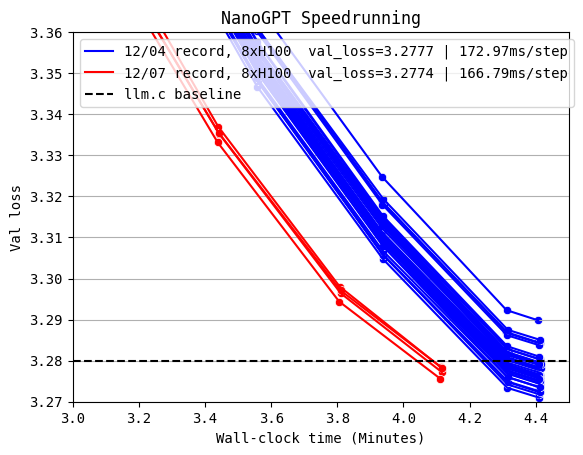

In [57]:
offset = 0
for i, palette in enumerate(color_palettes):
    n = len(all_filenames[i])
    avg_final_val_loss = np.mean(final_val_losses[offset:offset+n])
    avg_ms_per_step = np.mean(step_avg[offset:offset+n])
    run_label = labels[i]

    for idx, (train_times_min_, val_loss) in enumerate(
        zip(train_times_min[offset:offset+n], val_losses[offset:offset+n])
    ):
        label = (
            f"{run_label:<22}val_loss={avg_final_val_loss:.4f} | {avg_ms_per_step:.2f}ms/step"
            if idx == 0
            else None
        )
        sns.scatterplot(x=train_times_min_, y=val_loss, linewidth=0.5, color=palette[idx])
        sns.lineplot(x=train_times_min_, y=val_loss, label=label, color=palette[idx])

    offset += n

plt.axhline(y=3.28, color="black", linestyle="--", label="llm.c baseline")

plt.title("NanoGPT Speedrunning")
plt.legend(loc="upper left")
plt.ylim(3.27, 3.36)
plt.yticks(np.linspace(3.27, 3.36, 10))
plt.xlim(3, 4.5)
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("Wall-clock time (Minutes)")
plt.savefig(f"{IMAGES_SAVE_PATH}/nanogpt_speedrun_wallclock.png")

## T-Tests

In [65]:
val_losses = final_val_losses[len(old_record_filenames) : len(old_record_filenames)+len(new_record_filenames)]
val_losses

[np.float64(3.2772),
 np.float64(3.2756),
 np.float64(3.2784),
 np.float64(3.2783)]

In [64]:
import scipy.stats
p_value = scipy.stats.ttest_1samp(val_losses, 3.28, alternative='less').pvalue
print('p=%.4f; %s' % (p_value, 'significant' if p_value < 0.05 else 'not significant'))

p=0.0137; significant


In [66]:
import torch
print(torch.std_mean(torch.tensor(val_losses)))


(tensor(0.0013, dtype=torch.float64), tensor(3.2774, dtype=torch.float64))
